In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
import pickle
import os

In [55]:
df = pd.read_csv("../../Datasets/3_earthquake_1995-2023.csv")

df.drop(columns=['title'], inplace=True)

Null values in dataset:
magnitude    0
cdi          0
mmi          0
alert        0
tsunami      0
sig          0
net          0
nst          0
dmin         0
gap          0
magType      0
depth        0
latitude     0
longitude    0
location     0
continent    0
country      0
day          0
month        0
year         0
dtype: int64


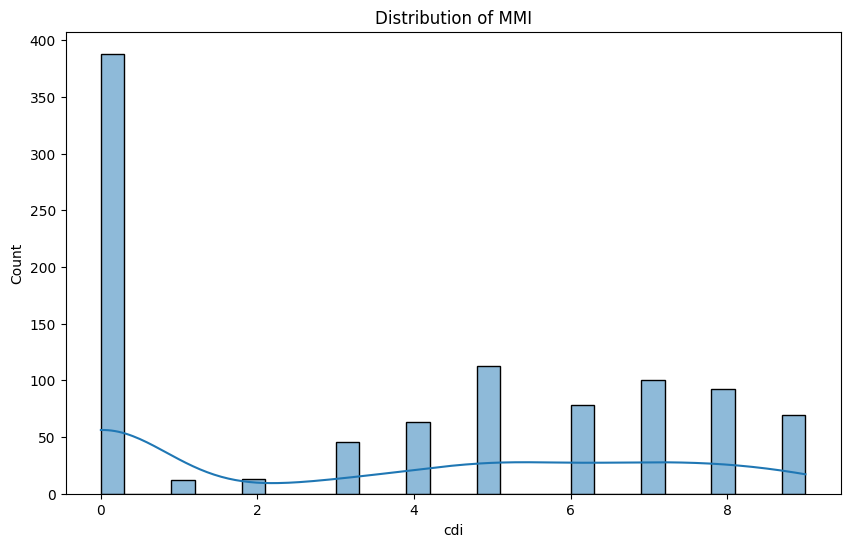

In [56]:
print("Null values in dataset:")
print(df.isna().sum())

plt.figure(figsize=(10, 6))
sns.histplot(df['cdi'], kde=True, bins=30)
plt.title('Distribution of MMI')
plt.show()

In [57]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [58]:
# Preprocessing
X = df.drop(columns=['cdi'])
y = df['cdi']

categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Initialize and fit transformers
transformers = {
    'label_encoders': {col: LabelEncoder().fit(X[col]) for col in categorical_features},
    'scaler': StandardScaler().fit(X[numerical_features]),
    'target_encoder': LabelEncoder().fit(y)
}

# Transform features
X_transformed = X.copy()
for col in categorical_features:
    X_transformed[col] = transformers['label_encoders'][col].transform(X[col])
X_transformed[numerical_features] = transformers['scaler'].transform(X[numerical_features])
y_transformed = transformers['target_encoder'].transform(y)


In [59]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [60]:
# Initial train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y_transformed, test_size=0.2, random_state=42, stratify=y_transformed
)

X_train_resampled, y_train_resampled = X_train, y_train


In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif

In [62]:
# Feature Selection
feature_selector_rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=feature_selector_rf, n_features_to_select=10)
kbest = SelectKBest(score_func=mutual_info_classif, k=10)

# Fit selectors
rfe.fit(X_train_resampled, y_train_resampled)
kbest.fit(X_train_resampled, y_train_resampled)
feature_selector_rf.fit(X_train_resampled, y_train_resampled)

# Get selected features
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_selector_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

selected_features = list(feature_importance.head(10)['Feature'])
print("\nTop 10 Selected Features:", selected_features)



Top 10 Selected Features: ['year', 'alert', 'sig', 'gap', 'longitude', 'latitude', 'depth', 'location', 'day', 'mmi']


In [63]:
from sklearn.model_selection import ShuffleSplit

In [64]:
# Prepare final datasets
X_train_final = X_train_resampled[selected_features]
X_test_final = X_test[selected_features]

# Model Training with ShuffleSplit
n_splits = 5
shuffle_split = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)


In [65]:
# Prepare final datasets
X_train_final = X_train_resampled[selected_features]
X_test_final = X_test[selected_features]

# Model Training with ShuffleSplit
n_splits = 3
shuffle_split = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)


In [66]:
from sklearn.metrics import classification_report, accuracy_score

In [67]:
# Parameter grid for RFC
param_grid = {
    'n_estimators': [200],
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

In [68]:
# Initialize lists to store results
cv_scores = []
models = []

# Train and evaluate models using ShuffleSplit
for fold, (train_idx, val_idx) in enumerate(shuffle_split.split(X_train_final), 1):
    # Split data for current fold
    X_fold_train = X_train_final.iloc[train_idx]
    y_fold_train = y_train_resampled[train_idx]
    X_fold_val = X_train_final.iloc[val_idx]
    y_fold_val = y_train_resampled[val_idx]
    
    # Train model with best parameters from grid search
    rfc = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )
    
    # Fit and evaluate
    rfc.fit(X_fold_train, y_fold_train)
    y_fold_pred = rfc.predict(X_fold_val)
    fold_score = accuracy_score(y_fold_val, y_fold_pred)
    
    cv_scores.append(fold_score)
    models.append(rfc)
    
    print(f"\nFold {fold} Accuracy: {fold_score:.4f}")

# Print cross-validation results
print(f"\nMean CV Score: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")


Fold 1 Accuracy: 0.5321

Fold 2 Accuracy: 0.4936

Fold 3 Accuracy: 0.4936

Mean CV Score: 0.5064 (+/- 0.0181)


In [69]:
# Select best model based on validation performance
best_model_idx = np.argmax(cv_scores)
best_rf = models[best_model_idx]

# Final evaluation on test set
y_pred_rf = best_rf.predict(X_test_final)
print("\nFinal Test Set Results:")
print(classification_report(y_test, y_pred_rf))
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")


Final Test Set Results:
              precision    recall  f1-score   support

           0       0.80      0.90      0.84        78
           1       0.50      0.50      0.50         2
           2       0.50      0.50      0.50         2
           3       0.17      0.11      0.13         9
           4       0.12      0.08      0.10        13
           5       0.44      0.48      0.46        23
           6       0.15      0.12      0.14        16
           7       0.46      0.60      0.52        20
           8       0.36      0.28      0.31        18
           9       0.36      0.29      0.32        14

    accuracy                           0.55       195
   macro avg       0.39      0.39      0.38       195
weighted avg       0.52      0.55      0.53       195

Test Set Accuracy: 0.5538


In [70]:
from sklearn.metrics import confusion_matrix

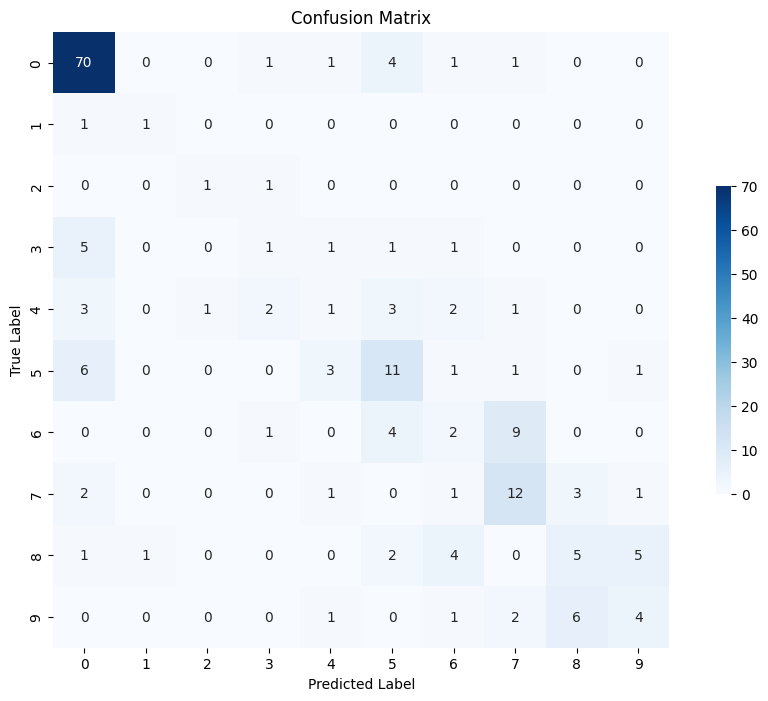

In [71]:
# Plot confusion matrix with better visualization
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            square=True, cbar_kws={"shrink": .5})
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

C:\Users\Akshat\AppData\Local\Temp\ipykernel_14084\255412528.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


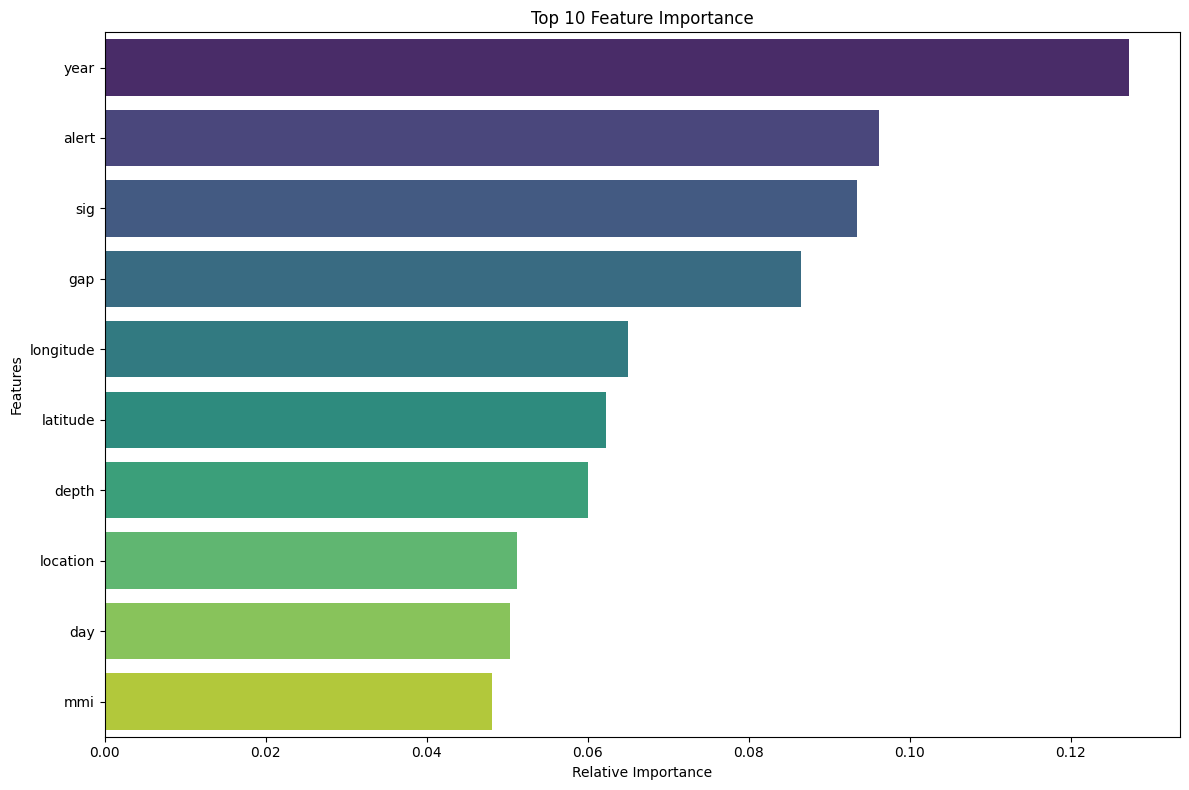

In [72]:
# Plot feature importance with improved styling
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', 
            data=feature_importance.head(10),
            palette='viridis')
plt.title('Top 10 Feature Importance')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [73]:
from pathlib import Path
import pickle

# Create the models directory path using Path
models_dir = Path("../../Notebooks/Predictions_Training/Models")

# Files to save
files_to_save = {
    'cdi_transformers.pkl': transformers,
    'cdi_selected_features.pkl': selected_features,
    'cdi_feature_info.pkl': {'categorical_features': list(categorical_features),
                             'numerical_features': list(numerical_features)},
    'cdi_model.pkl': best_rf
}

# Save all necessary files
for filename, content in files_to_save.items():
    file_path = models_dir / filename  # Use / to combine Path object and filename
    with open(file_path, 'wb') as f:
        pickle.dump(content, f)

print(f"\nAll model artifacts saved in {models_dir}")



All model artifacts saved in ..\..\Notebooks\Predictions_Training\Models
